In [11]:
from sklearn.svm import LinearSVC, SVC
from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt

from cv_svm import SVM_smooth
from kernel_svm import SVM_smooth_kernel
from sampler import sample_from_logreg

from sklearn.gaussian_process.kernels import RBF

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
#X, y = load_breast_cancer(return_X_y=True)
#X, y = make_classification(n_samples=250, n_features=20, random_state=100, class_sep=0.35)
#X = np.random.randn(300, 2)
#y = np.array(np.logical_xor(X[:, 0] > 0, X[:, 1] > 0), dtype=int)

#X, _, y = sample_from_logreg(n=1000, p=20, seed=120)
X, _, y = sample_from_logreg(n=1000, p=20, seed=120)
n = X.shape[0]
p = X.shape[1]
y[np.where(y == True)] = 1
y[np.where(y == False)] = 0 
y[np.where(y == 0)] = -1

In [3]:
from sklearn.model_selection import StratifiedKFold
n_splits = 5 
scale_data = True

In [4]:
sv_accs = []
skf = StratifiedKFold(n_splits=n_splits)
print("testing for sklearn CV")
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"\t running fold {i + 1}", end='')
    X_cv = X[train_idx]
    
    if scale_data:
        scaler = StandardScaler()
        scaler.fit(X_cv)

        X_scaled = scaler.transform(X_cv)
    else:
        X_scaled = X_cv

    clf = LinearSVC(loss='hinge', C=1, random_state=3)
    #clf = SVC()
    clf.fit(X_scaled, y[train_idx])

    if scale_data:
        y_pred = clf.predict(scaler.transform(X[test_idx]))
    else:
        y_pred = clf.predict(X[test_idx])
        
    y_pred_train = clf.predict(X_scaled)
        
    print(f" train_acc {accuracy_score(y[train_idx], y_pred_train)} : val_acc {accuracy_score(y[test_idx], y_pred)}")
    sv_accs.append(accuracy_score(y[test_idx], y_pred))
print(np.mean(sv_accs))

testing for sklearn CV
	 running fold 1 train_acc 0.72875 : val_acc 0.645
	 running fold 2 train_acc 0.72375 : val_acc 0.65
	 running fold 3 train_acc 0.68125 : val_acc 0.76
	 running fold 4 train_acc 0.715 : val_acc 0.7
	 running fold 5 train_acc 0.705 : val_acc 0.685
0.688


/home/sina/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sina/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sina/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sina/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/sina/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [5]:
# calculate maximum bound
from sklearn.metrics import pairwise_distances
m_max = np.min(pairwise_distances(X))**2
print(m_max)

C = np.linalg.norm(X.T @ X)/(n - 1)

# what lambda do we have to pick?
b = 1000

0.0


In [6]:
#sigmas = [2e-15, 2e-10, 2e-5, 2e-3, 2e-2, 2e-1, 5e-1, 7e-1, 1, 1.5, 2, 2.5]
sigmas = [2e-5, 2e-3, 2e-2, 2e-1, 5e-1, 7e-1, 1, 1.5, 2, 2.5]
print(sigmas)
accuracies = []
all_grads = []
lbd = 1

for s in sigmas:
    accs = []
    skf = StratifiedKFold(n_splits=n_splits)
    lbd_pick = C/((b - 1) * s) *\
                1/(2 * np.sqrt(1 + (m_max/s)**2)**3)
    if lbd_pick > 1e4:
        continue
        
    print(lbd_pick)
    lbd_pick = max(lbd_pick, lbd)
        
    print(f"testing for sigma = {s} | lbd = {lbd_pick}")
    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"\t running fold {i + 1}", end='')
        X_cv = X[train_idx]
        if scale_data:
            scaler = StandardScaler()
            scaler.fit(X_cv)

            X_scaled = scaler.transform(X_cv)
        else:
            X_scaled = X_cv
        lr = 0.5/n
        
        #length_scale = 2
        #clf = SVM_smooth_kernel(sigma=s, lbd=1, kernel=RBF(length_scale))
        #clf.fit(X_scaled, y[train_idx], thresh=1e-4, n_iter=2500, eta=lr, approx_cv=False, cv=False)

        num_iter = 10_000
        clf_lbd1 = SVM_smooth(sigma=s, lbd=lbd)
        clf_lbd1.fit(X_scaled, y[train_idx], thresh=1e-8, n_iter=num_iter, eta=lr, approx_cv=False, cv=False, save_grads=True, adjust_factor=True)
        
        clf = SVM_smooth(sigma=s, lbd=lbd_pick)
        clf.fit(X_scaled, y[train_idx], thresh=1e-8, n_iter=num_iter, eta=lr, approx_cv=False, cv=False, save_grads=True, adjust_factor=True)
        
        if scale_data:
            y_pred_l1 = clf_lbd1.predict(scaler.transform(X[test_idx]))
            y_pred = clf.predict(scaler.transform(X[test_idx]))
        else:
            y_pred_l1 = clf_lbd1.predict(X[test_idx])
            y_pred = clf.predict(X[test_idx])

        y_pred_train = clf.predict(X_scaled)
            
        print(f" : acc {accuracy_score(y[test_idx], y_pred)} | grad { np.linalg.norm(clf.nabla_fgd_(clf.weights_, X_scaled, y[train_idx], clf.sigma_, clf.lbd_))}")
        #print(f" train_acc {accuracy_score(y[train_idx], y_pred_train)} : val_acc {accuracy_score(y[test_idx], y_pred)} | grad { np.linalg.norm(clf.nabla_fgd_(clf.u_, clf.gram_, y[train_idx], clf.sigma_, clf.lbd_))}")
        accs.append((accuracy_score(y[test_idx], y_pred_l1), accuracy_score(y[test_idx], y_pred)))

    accuracies.append(accs)
    print(f"mean CV accuracy is {np.mean(accs)}")
    #all_grads.append(np.linalg.norm(clf.grads_, axis=1))

[2e-05, 0.002, 0.02, 0.2, 0.5, 0.7, 1, 1.5, 2, 2.5]
112.20913378353632
testing for sigma = 2e-05 | lbd = 112.20913378353632
	 running fold 1stopping early at iteration 308
 : acc 0.645 | grad 9.069775130782533e-09
	 running fold 2stopping early at iteration 308
 : acc 0.64 | grad 8.997925950125339e-09
	 running fold 3stopping early at iteration 306
 : acc 0.75 | grad 9.335054846268402e-09
	 running fold 4stopping early at iteration 307
 : acc 0.705 | grad 8.961391254201905e-09
	 running fold 5stopping early at iteration 307
 : acc 0.71 | grad 9.008709192713172e-09
mean CV accuracy is 0.6925
1.1220913378353632
testing for sigma = 0.002 | lbd = 1.1220913378353632
	 running fold 1 : acc 0.65 | grad 0.0006753948578821706
	 running fold 2 : acc 0.64 | grad 0.0008483918542120776
	 running fold 3 : acc 0.755 | grad 0.0006759232005976007
	 running fold 4 : acc 0.71 | grad 0.0007898578099788223
	 running fold 5 : acc 0.715 | grad 0.0007786374555024285
mean CV accuracy is 0.6944999999999999
0.11

In [7]:
means = []
means = np.mean(accuracies, axis=1)
means = np.asarray(means)
means

array([[0.695, 0.69 ],
       [0.695, 0.694],
       [0.694, 0.694],
       [0.693, 0.693],
       [0.693, 0.693],
       [0.693, 0.693],
       [0.693, 0.693],
       [0.693, 0.693],
       [0.693, 0.693],
       [0.693, 0.693]])

In [12]:
fig, ax = plt.subplots()
ax.plot(sigmas, means[:, 1], label="$\lambda = \lambda_b$", c='skyblue')
ax.plot(sigmas, means[:, 0], label=f"$\lambda = {lbd}$", c='salmon', linestyle="--")
ax.legend()
ax.set_xscale("log")
ax.set_xlabel("$\sigma$")
ax.set_ylabel(f"Mean {n_splits}-Fold CV Accuracy")

ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
plt.savefig('svmtest_logreg_sigma_accuracy_comb.pgf', bbox_inches='tight', pad_inches=0)

/tmp/ipykernel_2735/3256515559.py:12: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()


IndexError: list index out of range

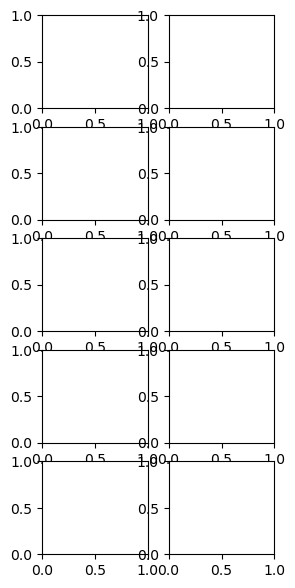

In [9]:
fig, axs = plt.subplots(5, 2, figsize=(3, 7))

for i, ax in enumerate(axs.flat):
    ax.plot(all_grads[i])
    ax.set_title(f"$\sigma$={sigmas[i]}")

plt.tight_layout()
ws = 1.15 # 1.75
hs = 0.55 # 1.25
#fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.tight_layout()
plt.show()
plt.savefig('svmtest_sigma_grads.pgf', bbox_inches='tight', pad_inches=0)

1. Generate data
    a. X ~ N(0, 1) iid
    b. X ~ N(0, Sigma) where Sigma is tri diagonal
    
    y = \sigma(w^T X_i + b) where w is sparse
    
2. Full CV for SVM for SVM when working well (good performance)
3. Full CV for \sigma-SVM (Soft) with \sigma \in {0, \ldots, 1}
4. IACV for \sigma-SVM with same sigmas - choose lambda

Kernel, redo data as Phi(X) for some kernel phi

high dim - try l1 reg with sigma svm and IACV
Does L_m correspoding to sigma-svm satisfy:
1. restricted strong convexity
2. \phi^* curvature